In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# GPU setting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

In [3]:
 # Data load

df = pd.read_csv('경기도_clustered.csv',index_col = 0,encoding = 'cp949')
df = df.T
df

date,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
2013-01-01,63.4,67.8,77.7,60.5,68.1,53.0,92.6,92.6,66.8,69.5,...,92.6,71.1,73.0,82.4,82.0,102.8,93.6,59.7,83.2,1.0
2013-02-01,63.3,67.2,77.4,60.2,67.7,52.9,92.5,90.9,66.6,69.0,...,92.8,70.9,72.9,82.0,81.7,102.8,93.6,59.1,83.0,1.0
2013-03-01,63.2,66.9,76.9,60.0,67.4,52.6,92.4,90.1,66.3,68.6,...,92.8,70.8,72.8,81.9,81.4,102.7,93.6,58.7,82.9,1.0
2013-04-01,63.3,67.1,76.4,59.8,67.4,52.6,92.4,90.0,66.3,68.1,...,93.5,70.7,73.2,82.3,81.7,102.7,93.9,58.6,82.9,1.0
2013-05-01,63.4,67.5,76.4,59.6,67.6,52.9,92.4,89.8,66.6,68.1,...,93.8,71.0,73.6,82.3,81.9,103.6,94.7,58.8,82.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,109.5,104.8,107.2,111.7,110.2,107.3,113.2,107.7,110.7,107.6,...,114.8,105.3,111.6,107.9,109.5,106.6,108.4,112.9,115.9,0.0
2021-12-01,109.8,105.1,107.4,112.0,110.8,107.4,114.1,107.5,111.2,108.0,...,116.1,105.6,111.6,108.4,109.8,107.2,109.0,113.0,116.7,0.0
2022-01-01,109.8,105.1,107.4,111.8,110.8,107.3,114.3,107.5,111.3,108.1,...,116.9,105.6,111.5,108.7,109.8,107.1,109.2,113.0,116.8,0.0
2022-02-01,109.6,105.0,107.3,111.6,110.7,107.3,114.3,107.4,111.3,108.0,...,117.0,105.6,111.0,108.7,109.7,107.1,109.3,112.9,116.6,0.0


In [4]:
data = pd.read_csv('경기도변수.csv',index_col = 0)
data


,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
date,,,,,,,,,,,,,,,,
2013-01-01,73.5,64.75625,93.900000,80.1,102.868,92.728,5.78,82.689331,76.007636,1089.0,1841.1,1961.90,503.67,8413721.0,54632,13631
2013-02-01,73.2,64.42500,93.666667,79.8,90.009,93.038,5.66,82.871183,76.108044,1083.0,1857.1,2026.50,535.87,7268443.0,65640,14925
2013-03-01,73.1,64.22500,93.550000,79.6,101.388,92.952,5.54,83.162722,76.376687,1111.0,1862.4,2004.90,555.02,10160177.0,87563,17718
2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,1867.7,1964.00,563.87,9757932.0,106498,22790
2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,1870.3,2001.05,577.87,10837979.0,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,3543.4,2970.68,992.33,14689855.0,119686,29187
2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,3594.7,2839.01,965.63,14483042.0,111172,26593
2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,3620.1,2977.65,1033.98,19169150.0,101766,25669


In [5]:
train = data.copy()
train 

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
date,,,,,,,,,,,,,,,,
2013-01-01,73.5,64.75625,93.900000,80.1,102.868,92.728,5.78,82.689331,76.007636,1089.0,1841.1,1961.90,503.67,8413721.0,54632,13631
2013-02-01,73.2,64.42500,93.666667,79.8,90.009,93.038,5.66,82.871183,76.108044,1083.0,1857.1,2026.50,535.87,7268443.0,65640,14925
2013-03-01,73.1,64.22500,93.550000,79.6,101.388,92.952,5.54,83.162722,76.376687,1111.0,1862.4,2004.90,555.02,10160177.0,87563,17718
2013-04-01,73.2,64.30000,93.766667,79.5,101.295,92.823,5.42,83.554044,76.858189,1101.0,1867.7,1964.00,563.87,9757932.0,106498,22790
2013-05-01,73.4,64.49375,94.116667,79.6,102.313,92.823,5.24,83.797077,77.090528,1129.7,1870.3,2001.05,577.87,10837979.0,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,103.5,107.45625,108.650000,108.8,114.800,103.350,3.47,102.450935,103.903947,1168.6,3543.4,2970.68,992.33,14689855.0,119686,29187
2021-11-01,104.1,108.45625,110.166667,109.8,119.300,103.870,3.58,102.917900,104.543227,1187.9,3594.7,2839.01,965.63,14483042.0,111172,26593
2021-12-01,104.4,108.79375,111.033333,110.2,126.700,104.040,3.68,103.178314,104.798091,1188.8,3620.1,2977.65,1033.98,19169150.0,101766,25669


In [6]:
train.corr()

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
seoul,1.000000,0.909367,0.227910,0.773868,0.655650,0.985362,-0.788762,0.821937,0.833499,0.511194,0.983945,0.713424,0.804257,0.120689,0.277253,0.461072
Avg_1,0.909367,1.000000,0.430139,0.952320,0.659035,0.914310,-0.738248,0.859271,0.864163,0.454030,0.950728,0.825427,0.851910,0.213492,0.145921,0.223406
Avg_2,0.227910,0.430139,1.000000,0.636631,0.263814,0.316192,-0.263846,0.629858,0.605018,0.122268,0.258434,0.404361,0.410531,0.467495,-0.122293,-0.113604
Avg_3,0.773868,0.952320,0.636631,1.000000,0.617700,0.802606,-0.595459,0.829918,0.825010,0.352483,0.825879,0.833771,0.805576,0.255809,-0.000097,0.046835
MMI,0.655650,0.659035,0.263814,0.617700,1.000000,0.643640,-0.508876,0.590326,0.592166,0.225834,0.660918,0.590472,0.575644,0.370323,0.317967,0.355939
CPI,0.985362,0.914310,0.316192,0.802606,0.643640,1.000000,-0.788664,0.860513,0.867821,0.477902,0.977648,0.736793,0.800200,0.135486,0.252717,0.434781
대출금리,-0.788762,-0.738248,-0.263846,-0.595459,-0.508876,-0.788664,1.000000,-0.883444,-0.897772,-0.557470,-0.827397,-0.575287,-0.730375,-0.416933,-0.542016,-0.611001
전세가격지수 전국,0.821937,0.859271,0.629858,0.829918,0.590326,0.860513,-0.883444,1.000000,0.998765,0.444093,0.854004,0.738510,0.832382,0.455081,0.319727,0.411201
전세가격지수 경기도,0.833499,0.864163,0.605018,0.825010,0.592166,0.867821,-0.897772,0.998765,1.000000,0.466121,0.866091,0.732316,0.833379,0.448879,0.337487,0.429138
환율,0.511194,0.454030,0.122268,0.352483,0.225834,0.477902,-0.557470,0.444093,0.466121,1.000000,0.525141,0.032797,0.228263,0.166043,0.125236,0.225640


In [7]:
# Training/Test ratio = 7:3

Train_ratio = 0.7

Test_ratio = 0.3

In [8]:
result =  pd.DataFrame(data=[0,0,0,0],
                             index = ['MAE','RMSE','MAPE', 'R2'],
                             columns=['test'])
result

,test
MAE,0
RMSE,0
MAPE,0
R2,0


In [9]:
for i in range(28):
    cluster = int(df[df.columns[i]][-1])
    answer = []
    for num in range(11):
        if abs(train.corr()['Avg_{}'.format(cluster+1)][num])>=0.7:
            answer.append(num)
    
    col =[]
    for j in  answer:
        col.append(train.columns[j])
    train[col]
    
    x = train[col].replace(',','')
    y = df.iloc[:-1,i:i+1]
    
    
    # Data Division

    train_x = x.iloc[0:int(len(df)*Train_ratio),:]

    train_y = y.iloc[0:int(len(df)*Train_ratio),:]

    test_x = x.iloc[int(len(df)*Train_ratio):,:]

    test_y = y.iloc[int(len(df)*Train_ratio):,:]


    # Normalizing , 둘다 학습하여 성능비교할것

    minmax = MinMaxScaler()

    standard = StandardScaler()



    train_x = minmax.fit_transform(train_x)

    train_y = minmax.fit_transform(train_y)

    test_x = minmax.fit_transform(test_x)

    test_y = minmax.fit_transform(test_y)





    # Numpy array상태로는 학습이 불가능하므로, Torch Variable 형태로 변경(data/grad/grad_fn)

    train_x_tensor = Variable(torch.Tensor(train_x))

    train_y_tensor = Variable(torch.Tensor(train_y))

    

    test_x_tensor = Variable(torch.Tensor(test_x))

    test_y_tensor = Variable(torch.Tensor(test_y))

    

    train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))

    train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))

    test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

    test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

    


    ## LSTM network modeling

    class LSTM_Jun(nn.Module):

        def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

            super(LSTM_Jun, self).__init__()

            self.num_classes = num_classes

            self.num_layers = num_layers

            self.input_size = input_size

            self.hidden_size = hidden_size

            self.seq_length = seq_length

            self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

            self.layer_1 = nn.Linear(hidden_size, 256)

            self.layer_2 = nn.Linear(256,256)

            self.layer_3 = nn.Linear(256,128)

            self.layer_out = nn.Linear(128, num_classes)

            self.relu = nn.ReLU() #Activation Func



        def forward(self,x):

            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States



            output, (hn, cn) = self.lstm(x, (h_0, c_0))



            hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

            out = self.relu(hn) #pre-processing for first layer

            out = self.layer_1(out) # first layer

            out = self.relu(out) # activation func relu

            out = self.layer_2(out)

            out = self.relu(out)

            out = self.layer_3(out)

            out = self.relu(out)

            out = self.layer_out(out) #Output layer

            return out

 

    # Code Main

    num_epochs = 500
    learning_rate = 0.005

    input_size = int(len(x.columns))

    hidden_size = 2 # number of features in hidden state

    num_layers = 1

    num_classes = int(len(y.columns))



    LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)



    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)

 

    for epoch in range(num_epochs) : 

        outputs = LSTM_Jun.forward(train_x_tensor_final.to(device))

        optimizer.zero_grad()

        loss = loss_function(outputs, train_y_tensor.to(device))

        loss.backward()

        optimizer.step() # improve from loss = back propagation

        if epoch % 100 == 0 :

            print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))
            

    # Estimated Value

    test_predict = LSTM_Jun(test_x_tensor_final.to(device)) #Forward Pass

    predict_data = test_predict.data.detach().cpu().numpy() #numpy conversion

    predict_data = minmax.inverse_transform(predict_data) #inverse normalization(Min/Max)
    

    # Real Value

    real_data = test_y_tensor.data.numpy() # Real value

    real_data = minmax.inverse_transform(real_data) #inverse normalization 
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

    
    MAE = mean_absolute_error(predict_data, real_data)
    RMSE = np.sqrt(mean_squared_error(predict_data, real_data))
    R2 = r2_score(predict_data, real_data)
    MAPE= np.mean(np.abs((y_test - y_pred) / y_test))
    pd.options.display.float_format = '{:.5f}'.format
    label = df.columns[i]
    Result = pd.DataFrame(data=[MAE,RMSE, MAPE,R2],
                         index = ['MAE','RMSE','MAPE','R2'],
                         columns=[label])
        
    

    result = pd.concat([result,Result],axis = 1)

Epoch : 0, loss : 0.34120
Epoch : 100, loss : 0.00110
Epoch : 200, loss : 0.00042
Epoch : 300, loss : 0.00025
Epoch : 400, loss : 0.00024


NameError: name 'y_test' is not defined

In [279]:
result.drop()

,test,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,...,이천시,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시
MAE,0,2.39925,3.25591,2.02854,3.02049,10.04844,4.93418,13.82369,4.65145,15.87973,...,1.99048,2.06770,5.30830,4.48867,9.29562,1.85301,3.29465,0.66280,2.56679,11.29667
RMSE,0,3.48003,4.38387,3.13609,3.74859,11.17379,5.41553,14.82377,5.22569,17.15526,...,2.85034,2.26310,6.64486,4.95712,10.16954,2.29250,3.66232,0.86425,3.50358,13.50078
MAPE,0,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,...,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608,0.99608
R2,0,0.93563,0.65549,0.89957,0.91530,0.00000,0.80085,0.00000,-1.00471,0.00000,...,0.82487,0.92992,0.22800,0.75118,0.00000,0.94063,0.00000,0.96641,0.95156,-17.58646


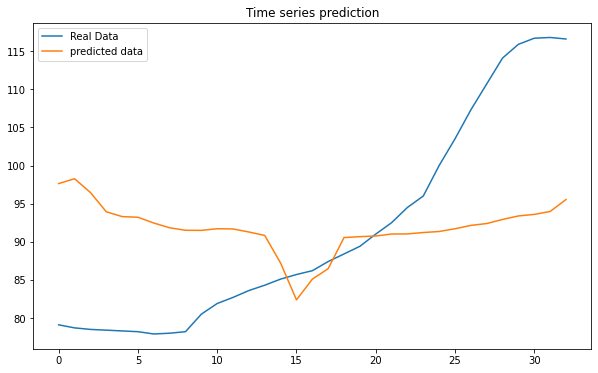

In [276]:
#Figure

plt.figure(figsize = (10,6)) # Plotting
plt.plot(real_data, label = 'Real Data')
plt.plot(predict_data, label = 'predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()